# 5.이미지 분류
## 5.1 개/고양이 예를 반려동물 품종으로 확장하기

In [1]:
# load dataset
from fastai.vision.all import *
path = untar_data(URLs.PETS)

path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [2]:
(path/"images").ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_31.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_153.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_176.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_194.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_140.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_86.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_23.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_76.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_26.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_39.jpg')...]

In [3]:
# test one file
fname = (path/"images").ls()[0]
re.findall(r"(.+)_\d+.jpg$", fname.name)  # 하나 이상의 숫자와 확장자 이전의 모든 문자 

['British_Shorthair']

In [4]:
# DataBlock
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r"(.+)_\d+.jpg$"), "name"),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [5]:
# item_tfms=Resize(460)  # 전체 너비나 높이를 기준으로 잘라내는 단계
# batch_tfms=aug_transforms(size=224, min_scale=0.75)  # 임의의 부분을 잘라낸 후 증강하는 단계

## 5.2 사전 크기 조절

- 이미지 증강 결과 확인 후 기본 모델로 빠르게 테스트를 권장함

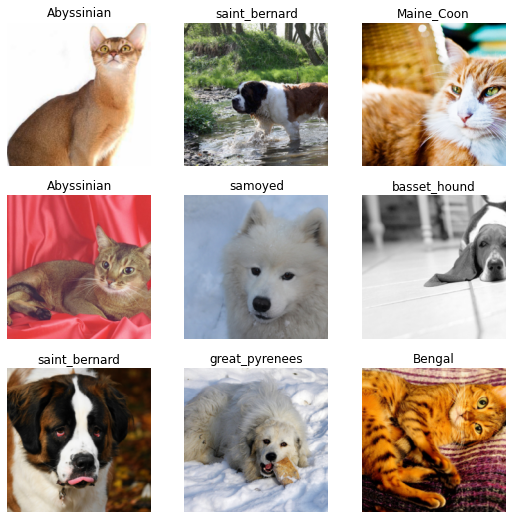

In [15]:
dls.show_batch(nrows=3, ncols=3)

In [ ]:
# 이미지 크기를 조절하는 부분이 빠진 경우 등 summary를 통해서 확인 가능
# error 출력 사례
pets_error = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       splitter=RandomSplitter(seed=42),
                       get_y=using_attr(RegexLabeller(r"(.+)_\d+.jpg$"), "name"))

pets_error.summary(path/"images")

In [8]:
# 기본 모델 사용을 통한 학습 검증
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.511230,0.335715,0.103518,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.516928,0.258870,0.079161,00:26
1,0.331311,0.218199,0.069689,00:26


## 5.3 교차 엔트로피 손실

- 종속 변수에 범주가 둘 이상이더라도 작동
- 더 빠르고 안정적인 학습 결과

In [16]:
x, y = dls.one_batch()
y  # 배치 크기는 64

TensorCategory([ 1, 23, 34,  1,  9, 35,  7, 22,  0, 17,  1, 21,  1, 25, 17, 26,  3, 17,
        19,  9, 16,  1,  2, 32, 21, 16,  2,  9, 30, 13, 26,  4,  2, 30,  0,  9,
        13,  9, 18, 27, 34, 32,  8, 25, 22, 32,  7, 16,  3, 26, 33,  7, 27, 33,
        15, 14, 34, 30, 24, 22, 31, 23, 32, 11], device='cuda:0')

In [18]:
preds, _ = learn.get_preds(dl=[(x, y)])
preds[0]  # 예측 결과의 첫 줄만 확인

TensorBase([8.4278e-05, 8.6926e-01, 3.4389e-06, 5.3675e-06, 7.4286e-06, 1.3035e-01,
        5.9740e-05, 1.8670e-06, 3.2737e-06, 3.7896e-07, 2.2319e-07, 3.9846e-06,
        1.7269e-07, 3.5864e-06, 1.3311e-06, 1.1565e-04, 1.3680e-06, 5.0435e-07,
        8.8430e-07, 1.7424e-05, 4.9776e-05, 4.2342e-06, 3.7241e-07, 5.9706e-07,
        1.1028e-08, 2.5926e-07, 3.8607e-07, 1.1174e-06, 2.3409e-07, 1.4285e-06,
        1.7469e-07, 1.2107e-06, 1.7300e-06, 3.4444e-06, 7.4283e-06, 1.8292e-06,
        6.5642e-06])

In [21]:
len(preds[0]), preds[0].sum().item()  # 모든 클래스의 확률합은 1

(37, 1.0)

### softmax

In [37]:
acts = torch.randn((6, 2)) * 2
acts

tensor([[-1.9208,  0.0805],
        [-1.1446, -3.4474],
        [ 1.1120,  1.5886],
        [ 0.7604, -1.0541],
        [ 1.9424,  2.0210],
        [-2.2200, -4.8854]])

In [38]:
acts.sigmoid()

tensor([[0.1278, 0.5201],
        [0.2415, 0.0308],
        [0.7525, 0.8304],
        [0.6815, 0.2584],
        [0.8746, 0.8830],
        [0.0980, 0.0075]])

In [39]:
(acts[:, 0] - acts[:, 1]).sigmoid()  # (1)

tensor([0.1191, 0.9091, 0.3830, 0.8599, 0.4804, 0.9349])

In [40]:
def softmax(x):
    return exp(x) / exp(x).sum(dim=1, keepdim=True)

In [42]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts   # (1)의 숫자 3일 확률과 동일

tensor([[0.1191, 0.8809],
        [0.9091, 0.0909],
        [0.3830, 0.6170],
        [0.8599, 0.1401],
        [0.4804, 0.5196],
        [0.9349, 0.0651]])

### Log likelihood

In [43]:
def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()

In [45]:
targ = tensor([0, 1, 0, 1, 1, 0])
targ

tensor([0, 1, 0, 1, 1, 0])

In [46]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.1191, 0.0909, 0.3830, 0.1401, 0.5196, 0.9349])

In [47]:
sm_acts

tensor([[0.1191, 0.8809],
        [0.9091, 0.0909],
        [0.3830, 0.6170],
        [0.8599, 0.1401],
        [0.4804, 0.5196],
        [0.9349, 0.0651]])

In [49]:
-sm_acts[idx, targ]

tensor([-0.1191, -0.0909, -0.3830, -0.1401, -0.5196, -0.9349])

In [51]:
F.nll_loss(sm_acts, targ, reduction="none")  # 위의 행위를 한 줄로 설명

tensor([-0.1191, -0.0909, -0.3830, -0.1401, -0.5196, -0.9349])